# 적대적 공격

8.3.1 학습된 모델 불러오기

In [12]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import json
import matplotlib.pyplot as plt

In [13]:
model = models.resnet101(pretrained = True)  # 토치비전은 여러 가지 학습된 모델 제공, pretrained = True명시하면 학습 완료된 모델 사용 가능
model.eval()  

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
# 실제 모델의 예측값을 보면 0부터 1000까지의 숫자가 나옴. 이 값은 이미지넷 데이터셋의 클래스를 가리킴
# 이 숫자를 사람이 알아볼 수 있는 클래스 이름과 이어주기

CLASSES = json.load(open('./imagenet_samples/imagenet_classes.json'))  # 숫자와 클래스 제목의 매칭정보가 담겨있음
idx2class = [ CLASSES[str(i)] for i in range(1000)]   # 번호를 레이블 이름으로 변환

8.3.2 공격할 이미지 불러오기

In [15]:
# 실제 공격은 학습용 데이터에 존재하지 않는 이미지로 가해질 것 이므로 데이터셋에 존재하지 않는 이미지를 준비

img = Image.open('imagenet_samples/corgie.jpg')
# 이미지넷과 같은 크기인 224 * 224 크기로 변경
img_transforms = transforms.Compose([transforms.Resize((224,224), Image.BICUBIC), transforms.ToTensor()])
# 3 * 224* 224 의 이미지를 1 * 3 * 224 * 224로 배치를 뜻하는 1차원을 늘려줌
img_tensor = img_transforms(img)
img_tensor = img_tensor.unsqueeze(0)

print("이미지 텐서 모양: ", img_tensor.size())

이미지 텐서 모양:  torch.Size([1, 3, 224, 224])


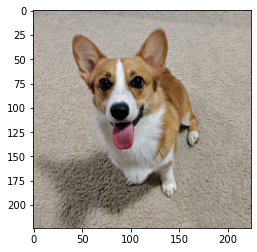

In [16]:
# 원본 이미지 시각화 위해 차원 줄이고 넘파이 행렬로 변환

original_img_view = img_tensor.squeeze(0).detach()  # detach함수로 원본 이미지 텐서와 연결 끊음
original_img_view = original_img_view.transpose(0,2).transpose(0,1).numpy()  # transpose함수로 뒤집힌 이미지를 제자리로 돌리고 맷플롯립 라이브러리와 호환하는 넘파이 행렬로 만듦
# 질문 : 왜 이미지가 뒤집혀 있는지?
plt.imshow(original_img_view)

8.3.3 공격 전 성능 확인하기

In [17]:
output = model(img_tensor)
prediction = output.max(1, keepdim = False)[1]  # 모델에서 나온 값이 max함수 이용하면 확률이 가장 높은 인덱스를 가져올 수 있음

prediction_idx = prediction.item()
prediction_name = idx2class[prediction_idx]

print("예측된 레이블 번호: ", prediction_idx)
print("레이블 이름: ", prediction_name)

예측된 레이블 번호:  263
레이블 이름:  Pembroke, Pembroke Welsh corgi


8.3.4 FGSM 공격 함수 정의

In [18]:
# 모델을 헷갈리게 하기 위해선 오찻값 극대화 해야함 -> 기울기 방향으로 최적화하도록 해서 오차를 키워야함

def fgsm_attack(image, epsilon, gradient):
    sign_gradient = gradient.sign()  # 기울기의 방향성 알기 위해 sign함수 적용. sign함수는 입력이 0보다 작으면 -1, 0이면 0, 0보다 크면 1 출력
    perturbed_image = image + epsilon * sign_gradient  # epsilon은 잡음이 너무 커지지 않고 사람의 눈에 보이지 않게 제한하는 역할
    perturbed_image = torch.clamp(perturbed_image,0,1)  # clamp함수는 값을 일정 범위로 묶는 역할
    return perturbed_image

8.3.5 적대적 예시 생성

In [19]:
img_tensor.requires_grad_(True)  # 원본 이미지에 대한 기울기 추출. requires_grad_함수 호출해 이미지에 대한 기울기 보존하도록 명시해야함
output = model(img_tensor)
loss = F.nll_loss(output, torch.tensor([263]))  # 263은 웰시코기

# 기울기 구하기
model.zero_grad()
loss.backward()

gradient = img_tensor.grad.data  # 역전파를 마치고 나면 img_tensor텐서의 grad.data변수에 입력 이미지의 기울기가 저장됨

# FHSM공격으로 적대적 예제 생성
epsilon = 0.03
perturbed_data = fgsm_attack(img_tensor, epsilon, gradient)

In [20]:
output = model(perturbed_data)  # 적대적 예제를 모델에 통과시켜 예측이 빗나가는지 확인

8.3.6 적대적 예제 성능 확인

In [21]:
perturbed_prediction = output.max(1,keepdim=False)[1]
perturbed_prediction_idx = perturbed_prediction.item()
perturbed_prediction_name = idx2class[perturbed_prediction_idx]

print("예측된 레이블 번호: ", perturbed_prediction_idx)
print("레이블 이름: ", perturbed_prediction_name)

예측된 레이블 번호:  172
레이블 이름:  whippet


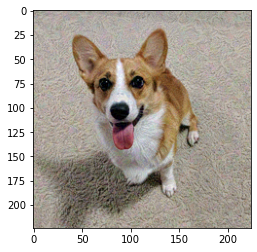

In [26]:
# 적대적 예제를 시각화하기

perturbed_data_view = perturbed_data.squeeze(0).detach()
perturbed_data_view = perturbed_data_view.transpose(0,2).transpose(0,1).numpy()

plt.imshow(perturbed_data_view)

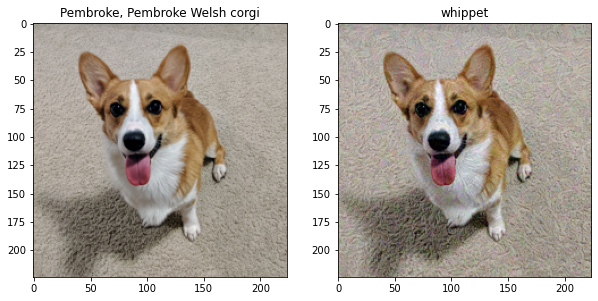

In [28]:
# 원본과 적대적 예제를 나란히 시각화하기

f,a = plt.subplots(1,2,figsize=(10,10))
# 원본
a[0].set_title(prediction_name)
a[0].imshow(original_img_view)
# 적대적 예제
a[1].set_title(perturbed_prediction_name)
a[1].imshow(perturbed_data_view)

plt.show()